In [43]:
import os
import cv2
os.chdir("Downloads/via-2.0.11")

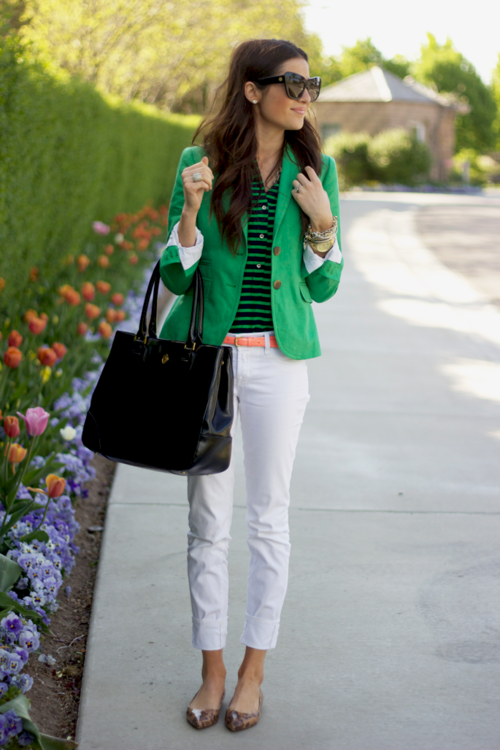

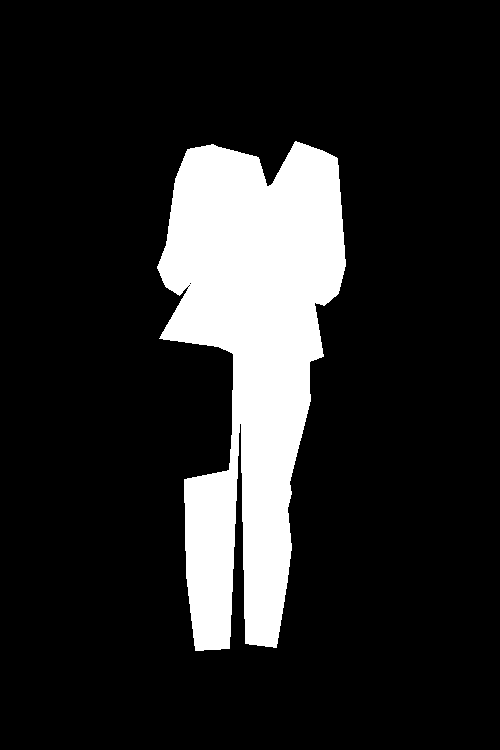

In [3]:
#Display an image & corresponding segmentation mask
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[7]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)

In [114]:
#Prepare paths of input images and target segmentation masks (convert mask to label-based annotation)
#source: github.com/nikhilroxtomar
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

#img_size = (750, 500)
num_classes = 4
batch_size = 1

def load_data(path):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    return images, masks

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    #x = cv2.resize(x, (500,750))
    x = x / 255.0 #normalization
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #x = cv2.resize(x, (500,750))
    label = 1 if "bohemian" in path else 2 if "preppy" in path else 3
    x = (label*(x))/ 255.0 
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.float32)
    return x

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        x = read_image(x)
        y = read_mask(y)
        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([750, 500, 3])
    masks.set_shape([750, 500, 1])
    return images, masks

def tf_dataset(x, y, batch=1):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(17)
    return dataset

path = "dataset/"
images, masks = load_data(path)
dataset = tf_dataset(images, masks)
test_dataset = dataset.take(2) 
train_dataset = dataset.skip(2)


In [ ]:
def display(display_list):
    plt.figure(figsize=(6, 4))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()
#make sure images still good after processing
sample_image, sample_mask= None, None
for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask
    sample_image= tf.reshape(sample_image, [750,500,3])
    sample_mask= tf.reshape(sample_mask, [750,500,1])
display([sample_image, sample_mask])

In [85]:
#Data augmentation (source: www.tensorflow.org/tutorials/images/transfer_learning)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

#data augmentation layer 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

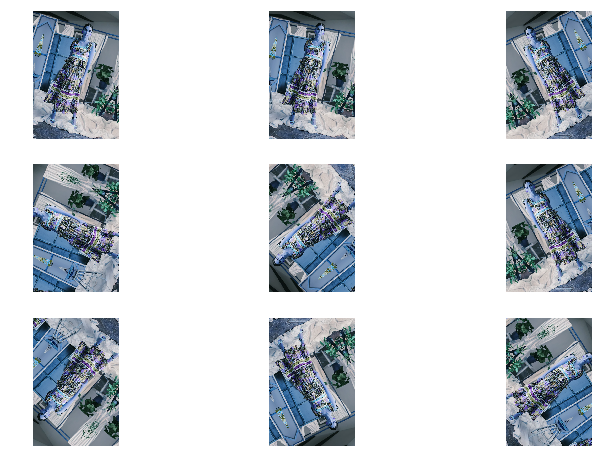

In [79]:
# see what augmentation does
for image, mask in train_dataset.take(1):
    plt.figure(figsize=(12, 8))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

In [103]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras import Input

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output

In [134]:
# 
# Encoder-Decoder model
# source: yann-leguilly.gitlab.io
dropout_rate = 0.5
input_size = (750, 500, 3)

initializer = 'he_normal'


# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
aug = data_augmentation(inputs)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(aug)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# -- Decoder -- #
# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_enc_2))
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(up_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# -- Dencoder -- #
N_CLASSES=4
output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)

In [135]:
model = tf.keras.Model(inputs = inputs, outputs = output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [138]:
EPOCHS = 2

STEPS_PER_EPOCH = 15
VALIDATION_STEPS = 2
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)


Epoch 1/2
15/15 [==============================] - 381s 25s/step - loss: 0.5607 - accuracy: 0.7806 - val_loss: 0.4774 - val_accuracy: 0.8256
Epoch 2/2
15/15 [==============================] - 353s 23s/step - loss: 0.4903 - accuracy: 0.7833 - val_loss: 0.2656 - val_accuracy: 0.8383


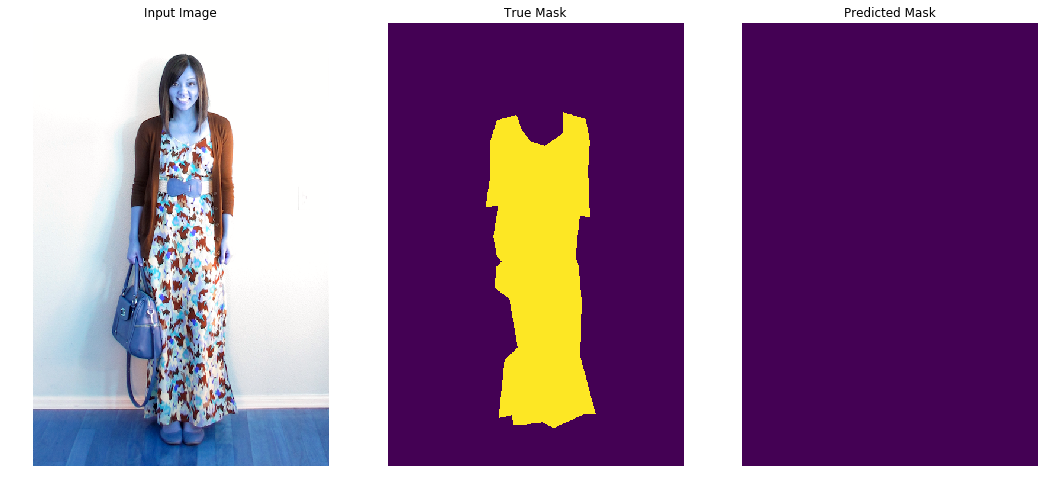

In [141]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask
show_predictions()